In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, StratifiedKFold
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
# pip install iterative-stratification
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelBinarizer, label_binarize
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [2]:
import os
os.getcwd()

'C:\\Users\\hanjh\\Desktop\\Kaggle project\\Fraud_Detection'

In [3]:
fraud_df = pd.read_csv('Fraud_Detection.csv')

### The below column reference:

- **step**: represents a unit of time where 1 step equals 1 hour 
- **type**: type of online transaction 
- **amount**: the amount of the transaction 
- **nameOrig**: customer starting the transaction 
- **oldbalanceOrg**: balance before the transaction 
- **newbalanceOrig**: balance after the transaction 
- **nameDest**: recipient of the transaction 
- **oldbalanceDest**: initial balance of recipient before the transaction 
- **newbalanceDest**: the new balance of recipient after the transaction 
- **isFraud**: fraud transaction

*Source*:  https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset?datasetId=2093649

In [4]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
fraud_df.drop(['step','nameOrig', 'nameDest','isFlaggedFraud'], axis=1, inplace=True) # drop uninformative variables

In [6]:
fraud_df.describe().round()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,179862.0,833883.0,855114.0,1100702.0,1224996.0,0.0
std,603858.0,2888243.0,2924049.0,3399180.0,3674129.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,13390.0,0.0,0.0,0.0,0.0,0.0
50%,74872.0,14208.0,0.0,132706.0,214661.0,0.0
75%,208721.0,107315.0,144258.0,943037.0,1111909.0,0.0
max,92445517.0,59585040.0,49585040.0,356015889.0,356179279.0,1.0


In [7]:
fraud_df.isnull().sum() # Check number of null values per cols

type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

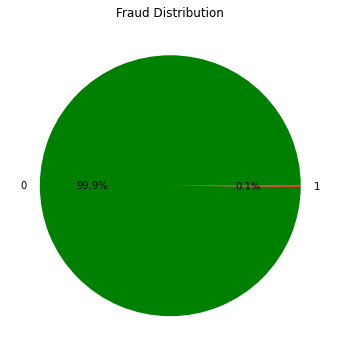

In [8]:
# Check distribution of outcome variables (Imbalanced outcome)
fraud_counts = fraud_df['isFraud'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Fraud Distribution')
plt.show() 

In [9]:
fraud_df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [10]:
type_dummies = pd.get_dummies(fraud_df['type'],prefix='Type')

In [11]:
fraud_df = pd.concat([fraud_df,type_dummies],axis=1)

In [12]:
fraud_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,Type_CASH_IN,Type_CASH_OUT,Type_DEBIT,Type_PAYMENT,Type_TRANSFER
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [13]:
X = fraud_df[['Type_CASH_IN','Type_CASH_OUT','Type_DEBIT','Type_PAYMENT','Type_TRANSFER','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]
y = fraud_df['isFraud']

### Binary classification task with oversampling (SMOTE) technique

In [36]:
# just to test SMOTE for balancing the two classes
# actual SMOTE step is incorporated into the pipelines below
smote=SMOTE(random_state=35)
x_smote, y_smote = smote.fit_resample(X, y)

In [37]:
print("Before Oversampling, the shape of X and Y: ", X.shape, y.shape)
print('After Oversampling, the shape of X and Y :', x_smote.shape, y_smote.shape) 

Before Oversampling, the shape of X and Y:  (6362620, 10) (6362620,)
After Oversampling, the shape of X and Y : (12708814, 10) (12708814,)


In [38]:
print(y.value_counts())
print(y_smote.value_counts())

0    6354407
1       8213
Name: isFraud, dtype: int64
0    6354407
1    6354407
Name: isFraud, dtype: int64


In [39]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=46)

In [ ]:
# pipeline for (1) SMOTE, (2) removing zero or near-zero variance predictors, (3) scaling, and (4) logistic regression models (Ridge and Lasso)
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [LogisticRegression(solver='saga', max_iter=10000, random_state=15)], 
 'Classifier__C': np.logspace(-3, 3, 7), 'Classifier__penalty': ['l1', 'l2'], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
grid_search_linear_smote = GridSearchCV(pipe, param_grid_linear, scoring='roc_auc', n_jobs=-1, cv=skfold).fit(X_train, y_train)

In [ ]:
# pipeline for (1), (2), (3), and (4) SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [SVC(kernel='linear', max_iter=10000, random_state=51)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [StandardScaler(), MinMaxScaler()], 
 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [SVC(kernel='rbf', max_iter=10000, random_state=27)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__gamma': np.logspace(-3, 3, 7), 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_smote = GridSearchCV(pipe, param_grid_svm, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(X_train, y_train)

In [ ]:
# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV AUC Linear={}'.format(grid_search_linear_smote.best_score_))
print('Best Test AUC Linear={}'.format(grid_search_linear_smote.score(x_test, y_test)))
y_pred = grid_search_linear_smote.predict(x_test)
print('Best Test Accuracy Linear={}'.format(np.mean(y_test==y_pred)))
print('Classification Report Linear:\n {}'.format(classification_report(y_test, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV AUC SVM={}'.format(grid_search_svm_smote.best_score_))
print('Best Test AUC SVM={}'.format(grid_search_svm_bin_smote.score(x_test, y_test)))
y_pred = grid_search_svm_bin_smote.predict(x_test)
print('Best Test Accuracy SVM={}'.format(np.mean(y_test==y_pred)))
print('Classification Report SVM:\n {}'.format(classification_report(y_test, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_smote.best_params_))

### Recall modeling

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [68]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [70]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

Approximately 0.1% of our data observations are in fact instances of fraud. That means that if our model were to never predict a payment to be fraud, it would still be nearly 99.9% accurate. The metric we use for comparison must take this into account which leaves us with three options: Precision, Recall, and F1 score.

**Precision**: Would measure how many of the payments the model identifies as fraud are actually fraudulent

**Recall**: Would measure how many of the actual fraudulent payments the model identified as fraud

**F1 Score**: A combination of the two

In reality, this would be a decision to be made by the stakeholders based on what they feel is more important in the model's predictions. For the sake of this exercise, we will be using recall as one could reasonably argue that correctly identifying cases of fraud is more important than sounding a 'false alarm'.

With the metric of comparison chosen, we will proceed to make predictions with our models and score them.

In [ ]:
from sklearn.metrics import recall_score

# Making predictions for our test data using our trained models
lr_y_pred = lr_model.predict(X_test)
dt_y_pred = dt_model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)

# Printing our results
print('Logistic Regression Recall:', recall_score(y_test, lr_y_pred))
print('Decision Tree Recall:', recall_score(y_test, dt_y_pred))
print('Random Forest Recall:', recall_score(y_test, rf_y_pred))

In [ ]:
# Importing the library to perform cross-validation
from sklearn.model_selection import cross_validate

# Running the cross-validation on both Decision Tree and Random Forest models; specifying recall as the scoring metric
dt_scores = cross_validate(dt_model, X_test, y_test, scoring='recall_macro')
rf_scores = cross_validate(rf_model, X_test, y_test, scoring='recall_macro')

# Printing the means of the cross-validations for both models
print('Decision Tree Recall Cross-Validation:', np.mean(dt_scores['test_score']))
print('Random Forest Recall Cross-Validation:', np.mean(rf_scores['test_score']))

In [55]:
from sklearn.preprocessing import Normalizer
norm = Normalizer()
cols = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', \
                   'oldbalanceDest', 'newbalanceDest', 'isFraud']
fraud_copy = fraud_df[cols].copy(deep=True)

In [56]:
normalized_val = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
fraud_copy[normalized_val] = norm.fit_transform(fraud_copy[normalized_val])
fraud_copy.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,PAYMENT,0.042057,0.727196,0.685140,0.000000,0.0,0
1,PAYMENT,0.064680,0.737225,0.672544,0.000000,0.0,0
2,TRANSFER,0.707107,0.707107,0.000000,0.000000,0.0,1
3,CASH_OUT,0.008544,0.008544,0.000000,0.999927,0.0,1
4,PAYMENT,0.222259,0.791534,0.569276,0.000000,0.0,0


<Figure size 432x288 with 0 Axes>

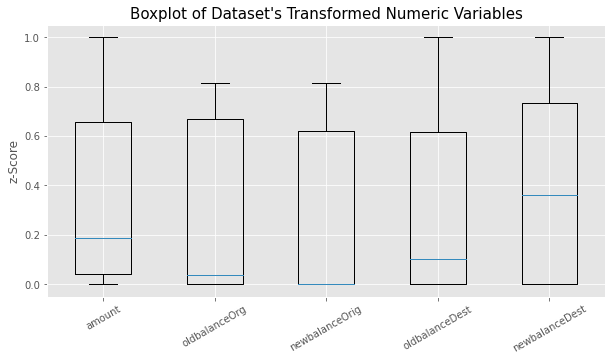

In [29]:
plt.clf()  # Clearing the previous plot formatting
fig, ax = plt.subplots(figsize=(10,5))  # Assigning axes variable and resizing plot
plt.boxplot(x=fraud_copy[normalized_val])  # Creating the boxplot
ax.set_xticklabels(normalized_val, rotation=30)  # Relabeling the x-axis
plt.ylabel('z-Score')
plt.title('Boxplot of Dataset\'s Transformed Numeric Variables', fontsize=15)  # Adding a title to the plot
plt.style.use('ggplot')  # Selecting a plot style to include gridlines
plt.show()  # Displaying the plot